## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [34]:
# import libraries
import re
import requests as req
import numpy as np
import pandas as pd
import assets.script as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import time
from calendar import Calendar

%matplotlib inline

In [35]:
# import sql library
from psycopg2 import sql
import psycopg2 as pg

# define paths
from pathlib import Path
data_path = Path('./data')

In [6]:
# display table names
display_tables = sc.sql_read_tables()
display_tables


# sc.sql_search_date(table='passengers', field='year', overwrite=True)

0             flights
1        flights_test
2    fuel_comsumption
3         pass_sample
4          passengers
5              sample
6           temptable
7          test_table
dtype: object

In [7]:
# # query for tables
# limit = 100000
# sample_size = '{}k'.format(int(limit/1000))


# for tables in display_tables:
#     query = sql.SQL(
#         "SELECT * FROM {t} \
#             LIMIT {l};").format(
#             t = sql.Identifier(tables),
#             l = sql.Literal(limit)
#         )
        
#     filename = '{}_{}_sample.csv'.format(tables, sample_size)
#     overwrite = True
    
#     # sql call
#     df = sc.make_csv(query, filename, overwrite)

In [10]:
sample_size = 100000

# transfer sample of tables to dataframes
df_flights = pd.read_csv(data_path / f'flights_{str(sample_size/1000)}k_sample.csv'.format(sample_size))
df_flights_test = pd.read_csv(data_path / f'flights_test_{str(sample_size/1000)}k_sample.csv'.format(sample_size))
df_fuel_comsumption = pd.read_csv(data_path / f'fuel_comsumption_{str(sample_size/1000)}k_sample.csv'.format(sample_size))
df_pass_sample = pd.read_csv(data_path / f'pass_sample_{str(sample_size/1000)}k_sample.csv'.format(sample_size))
df_passengers = pd.read_csv(data_path / f'passengers_{str(sample_size/1000)}k_sample.csv'.format(sample_size))
df_sample = pd.read_csv(data_path / f'sample_{str(sample_size/1000)}k_sample.csv'.format(sample_size))
df_temptable = pd.read_csv(data_path / f'temptable_{str(sample_size/1000)}k_sample.csv'.format(sample_size))

df_table_names = [df_flights, df_flights_test, df_fuel_comsumption, df_pass_sample, df_passengers, df_sample, df_temptable]

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

##### Look for columns describing delay

In [11]:
# search for columns that describe delays
regex = r"(.*delay.*)"
indices, results = sc.search_data(df_flights, regex)
results

['dep_delay',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

##### Preliminary EDA

In [12]:
print(df_flights[results].isnull().sum())
# most delays appear to have many missing values; will ignore them for now

dep_delay                422
arr_delay                650
carrier_delay          85969
weather_delay          85969
nas_delay              85969
security_delay         85969
late_aircraft_delay    85969
dtype: int64


In [13]:
# early arrivals|departures without null values
df_flights_delay = df_flights[['dep_delay', 'arr_delay']].dropna().reset_index(drop=True)
print(df_flights_delay.isnull().sum())
print(df_flights_delay.index)
df_flights_delay.describe()

dep_delay    0
arr_delay    0
dtype: int64
RangeIndex(start=0, stop=99350, step=1)


,dep_delay,arr_delay
count,99350.000000,99350.000000
mean,6.316457,0.770810
std,40.124939,41.765821
min,-40.000000,-65.000000
25%,-6.000000,-15.000000
50%,-3.000000,-7.000000
75%,2.000000,4.000000
max,1511.000000,1484.000000


These numbers are terrible.

##### Check for normal distributions

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.31353503465652466 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 19076.107367427525 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 11.32436073610048
kurtosis, tail spread (< 3 is best): 232.39906150149878


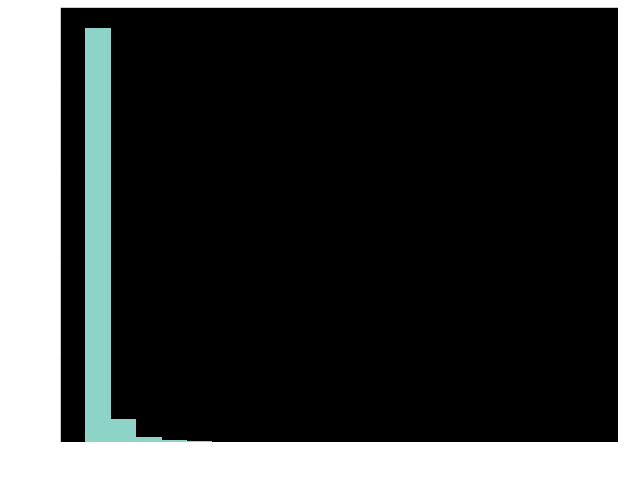

In [14]:
sc.check_normal_dist(df_flights_delay['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.48025423288345337 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 12146.140290412062 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 10.092117183882117
kurtosis, tail spread (< 3 is best): 199.0824797878961


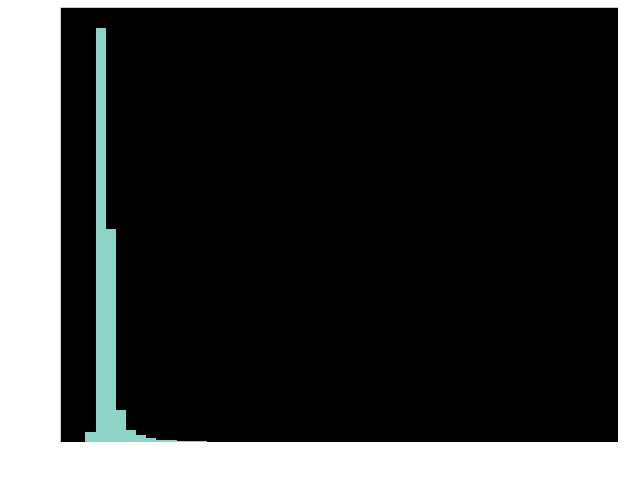

In [15]:
sc.check_normal_dist(df_flights_delay['arr_delay'], bins=50)

These are really not normal. Also, extremely skewed.

##### Filter outliers and redo the normal distribution checks

In [16]:
df = sc.filter_outliers(df_flights_delay, df_flights_delay['arr_delay'])
df.reset_index(inplace=True, drop=True)
df = sc.filter_outliers(df, df['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.9429877996444702 , p-value: 3.172539723231386e-40

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 1620.6551878484897 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.2435752185773583
kurtosis, tail spread (< 3 is best): 3.2753797598957948


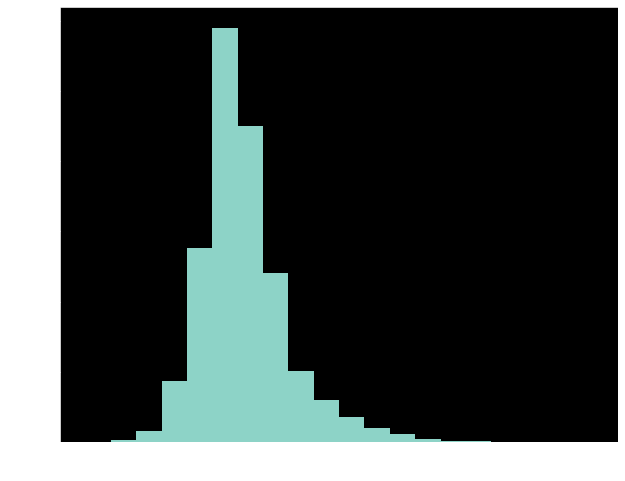

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7305164337158203 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 7864.145524521999 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.3714698364999696
kurtosis, tail spread (< 3 is best): 6.470939457473962


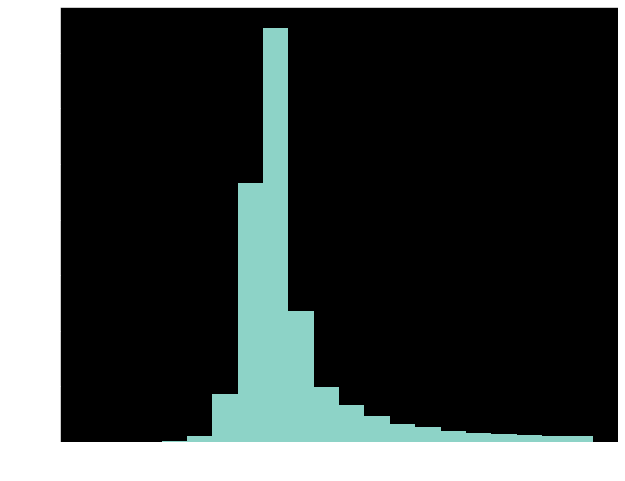

,dep_delay,arr_delay
count,94995.000000,94995.000000
mean,0.138881,-5.412559
std,11.936077,16.535989
min,-40.000000,-65.000000
25%,-6.000000,-16.000000
50%,-3.000000,-8.000000
75%,1.000000,2.000000
max,60.000000,126.000000


In [17]:
sc.check_normal_dist(df['arr_delay'])
sc.check_normal_dist(df['dep_delay'])
df.describe()

These are much better. The mean trends closer to zeo, and the max values aren't nearly so bad. Though, it still skews positive, these numbers make more sense.

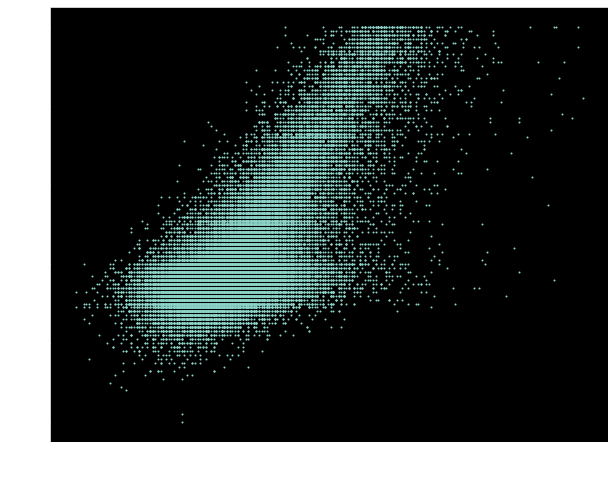

In [18]:
sc.graph_eda('scatter', df['arr_delay'], df['dep_delay'], marker_size=1)

There appears to be a correlation between the two, arr_delay and dep_delay. What's interesting is that the effect of departure delays on arrival delays appear to be wide one way. Arrival delay is less correlated to departure than the other way around.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

##### Define a function that takes samples per time period

In [19]:
# search for columns that describe delays
regex = r"(.*date.*)"

for i, table in enumerate(df_table_names):
    indices, results = sc.search_data(table, regex)
    # print(i)
    # print(indices)
    print(results)

['fl_date']
['fl_date']
[]
[]
[]
['fl_date']
['fl_date']


Only one column with associated dates. Take 100k samples from each month.

In [20]:
df_flights_by_month = []

for i in range(0,12):
    df_flights_by_month.append(sc.sql_search_date(table='flights', y=2019, m=i+1).sort_values(by='fl_date'))

File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...


1
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 4.076771506832445
kurtosis, tail spread (< 3 is best): 29.194332571172744


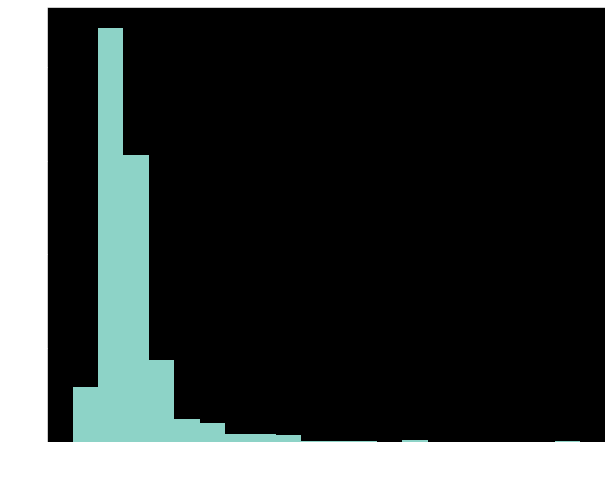

2
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 3.3092910154031134
kurtosis, tail spread (< 3 is best): 14.415180254222719


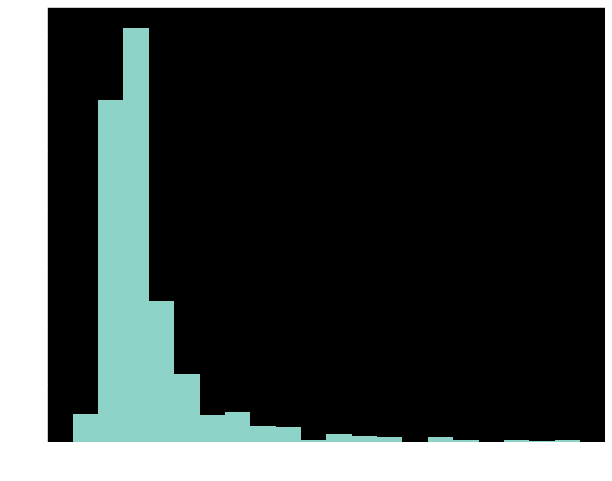

3
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 10.69161810313728
kurtosis, tail spread (< 3 is best): 203.42333516981793


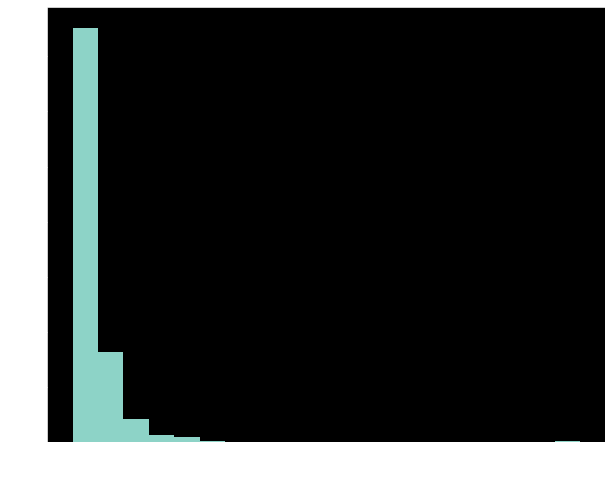

4
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 3.6419389022807085
kurtosis, tail spread (< 3 is best): 16.548504337114633


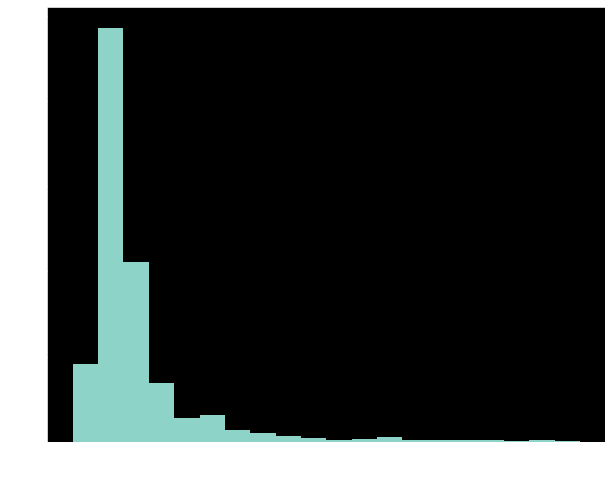

5
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.096366846890761
kurtosis, tail spread (< 3 is best): 65.09631244456328


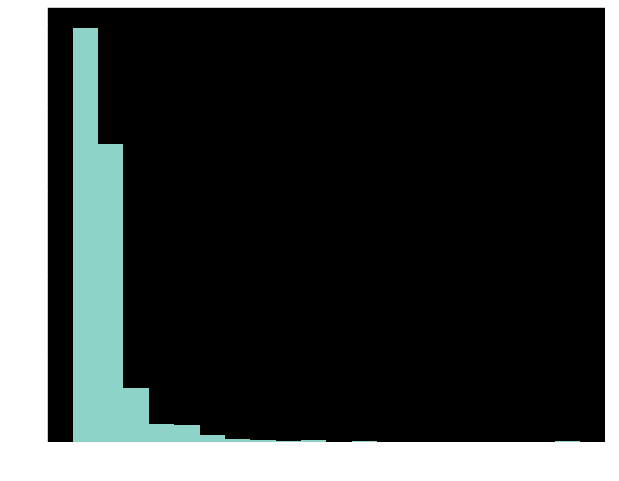

6
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.928024003084456
kurtosis, tail spread (< 3 is best): 95.09745531990558


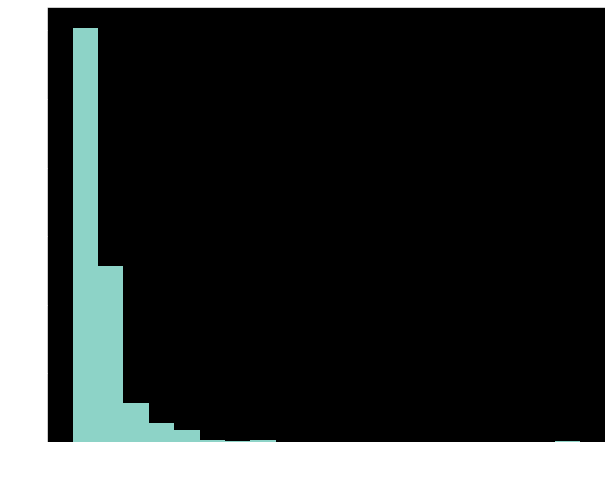

7
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 7.206008967324392
kurtosis, tail spread (< 3 is best): 90.67882641208895


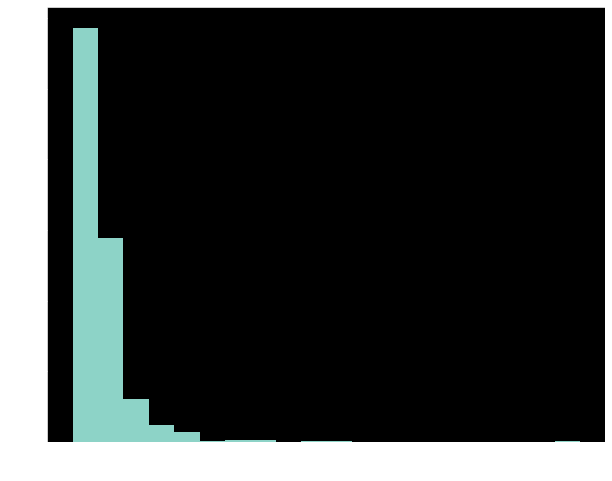

8
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 9.18796399775537
kurtosis, tail spread (< 3 is best): 118.5313573415164


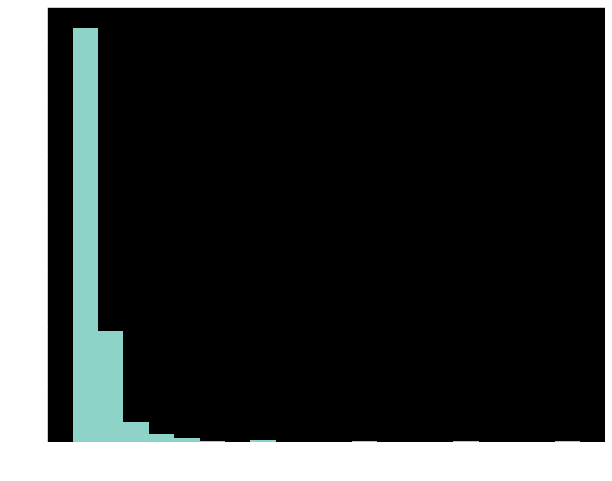

9
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 5.357618230922064
kurtosis, tail spread (< 3 is best): 43.82239401300713


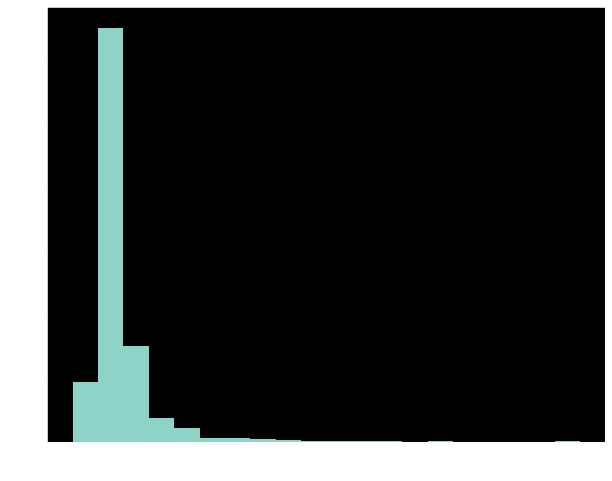

10
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 8.499790487797295
kurtosis, tail spread (< 3 is best): 122.33825085342599


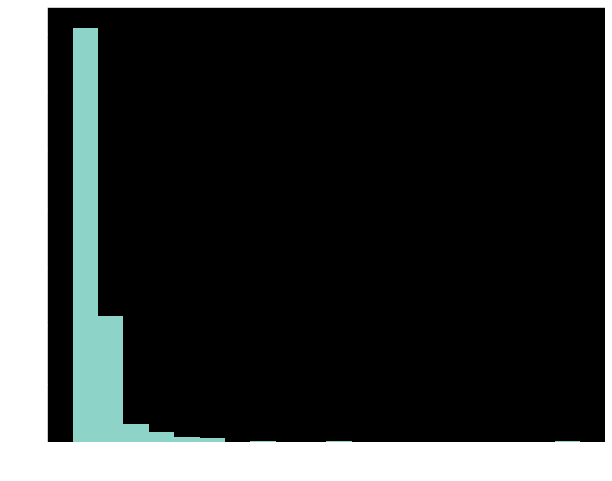

11
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 7.662502817084104
kurtosis, tail spread (< 3 is best): 89.81309990537453


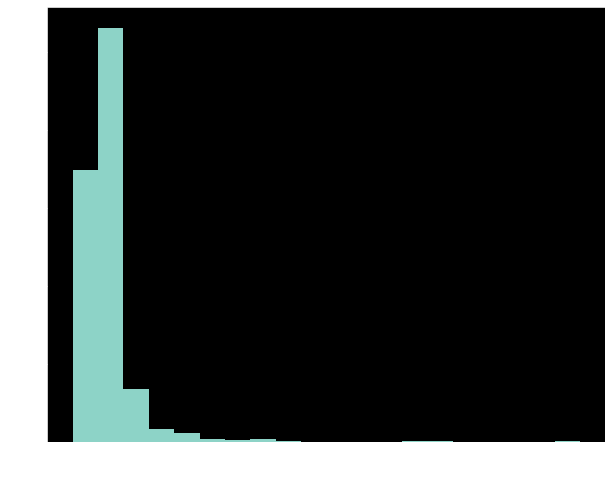

12
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 10.173708339484522
kurtosis, tail spread (< 3 is best): 148.50960512950198


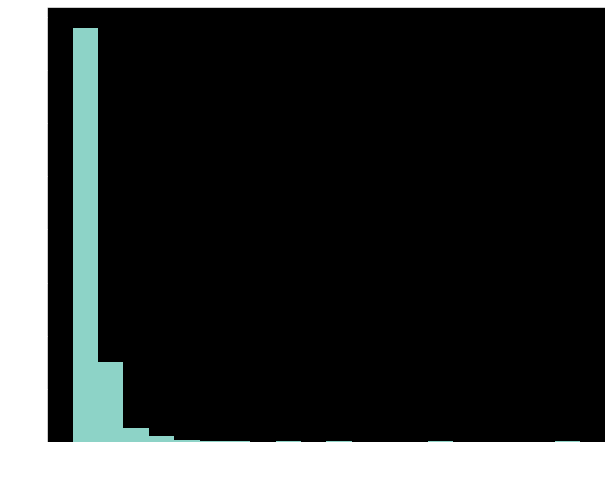

In [21]:
for i,month in enumerate(df_flights_by_month):
    print(i+1)
    sc.check_normal_dist(month['arr_delay'])

In [22]:
df_flights_by_month_noouts = []

for month in df_flights_by_month:
    df_flights_by_month_noouts.append(sc.filter_outliers(month.dropna(subset=['arr_delay']), month['arr_delay'].dropna()))

1
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8869959712028503 , p-value: 1.0404080635567469e-25

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 27.02486204366835 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.5513168424717159
kurtosis, tail spread (< 3 is best): 3.4511594016642366


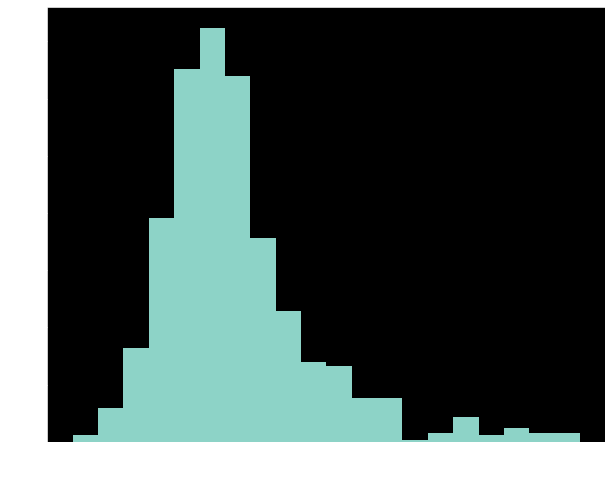

2
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8127589821815491 , p-value: 1.4583990480920314e-31

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 52.850406769870915 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.9349943945491146
kurtosis, tail spread (< 3 is best): 4.272964677968279


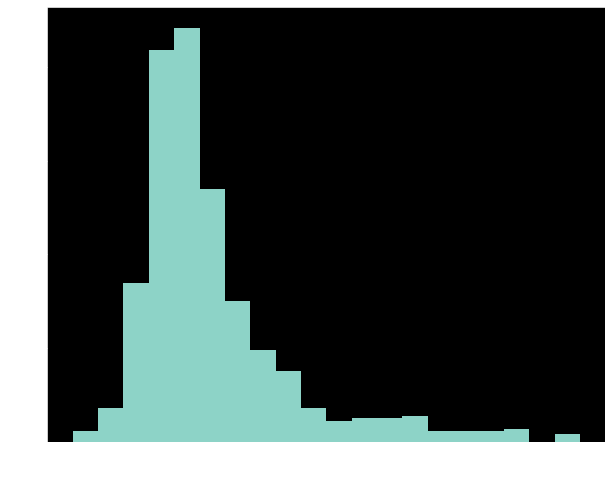

3
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7815685272216797 , p-value: 5.120965375072965e-34

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 58.25951663796968 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.2842520621068423
kurtosis, tail spread (< 3 is best): 6.522651892262038


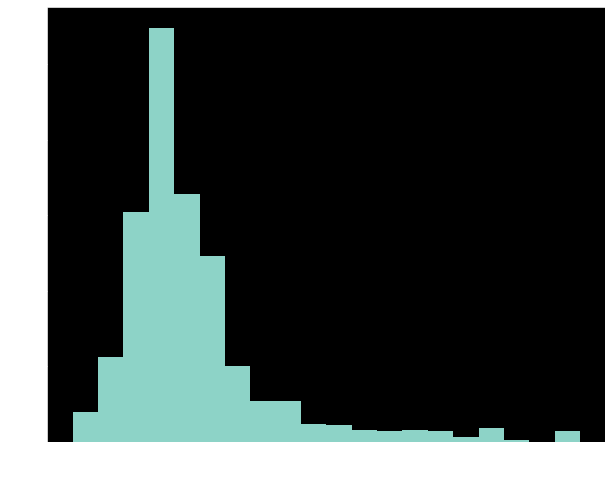

4
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7812581658363342 , p-value: 8.573700391527634e-34

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 62.72512504782571 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.1511324671657484
kurtosis, tail spread (< 3 is best): 5.332441414304253


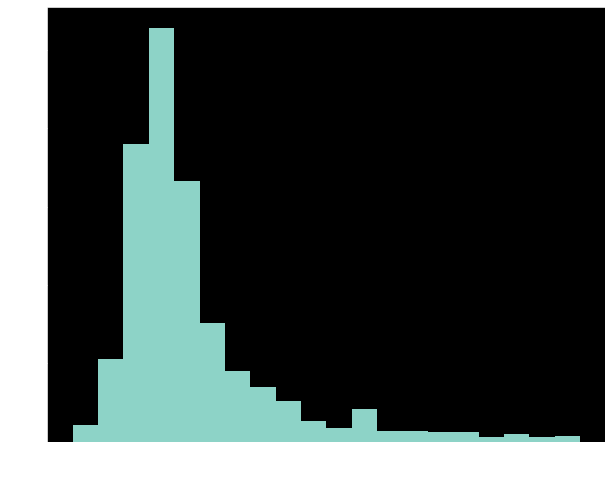

5
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7650938034057617 , p-value: 7.747816427739126e-35

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 66.95905012966921 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.276909199601086
kurtosis, tail spread (< 3 is best): 5.99141205678295


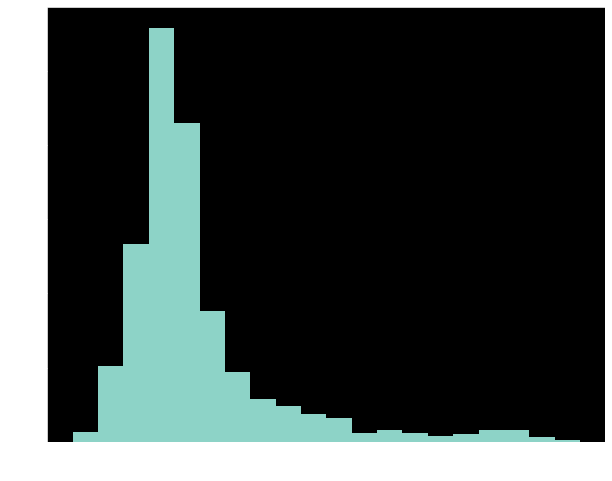

6
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7597800493240356 , p-value: 4.200464332742211e-35

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 72.43739448661177 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.193666976315067
kurtosis, tail spread (< 3 is best): 5.2074621836301525


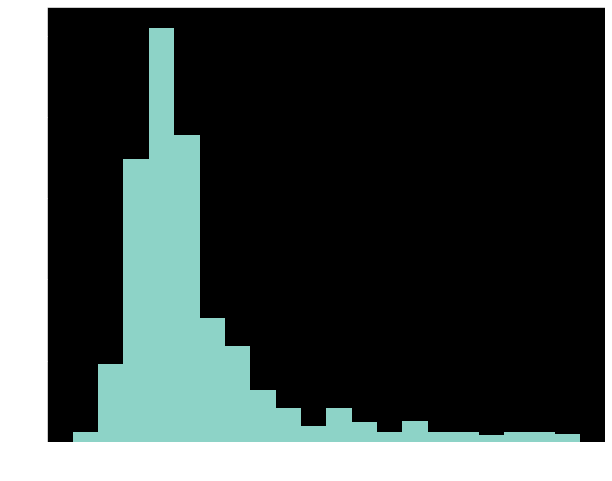

7
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.758459210395813 , p-value: 2.3155201111128058e-35

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 72.74656754111038 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.2714811041985614
kurtosis, tail spread (< 3 is best): 5.865670071242295


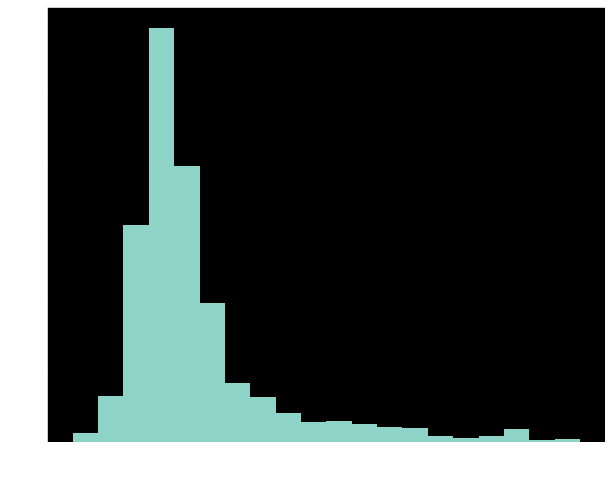

8
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7285990118980408 , p-value: 5.9473931843649315e-37

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 75.49320049302605 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.6467813589506184
kurtosis, tail spread (< 3 is best): 8.743308806727304


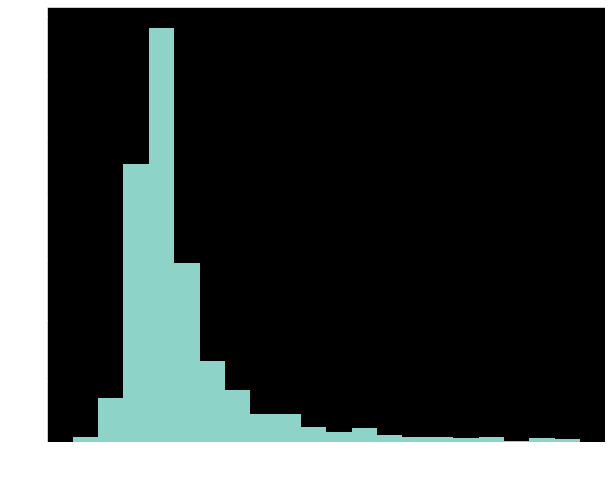

9
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.82261061668396 , p-value: 3.3056257665603574e-31

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 44.67210415459692 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.089250070506437
kurtosis, tail spread (< 3 is best): 6.169594083578669


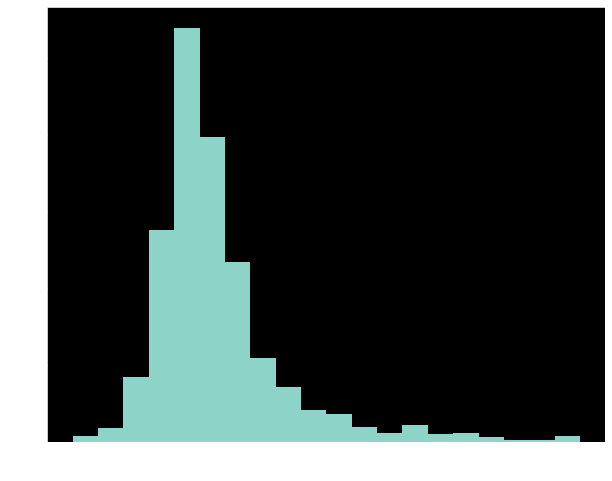

10
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7802807092666626 , p-value: 3.1415256421393526e-34

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 56.653458167308145 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.3837631736608635
kurtosis, tail spread (< 3 is best): 7.5414049109255075


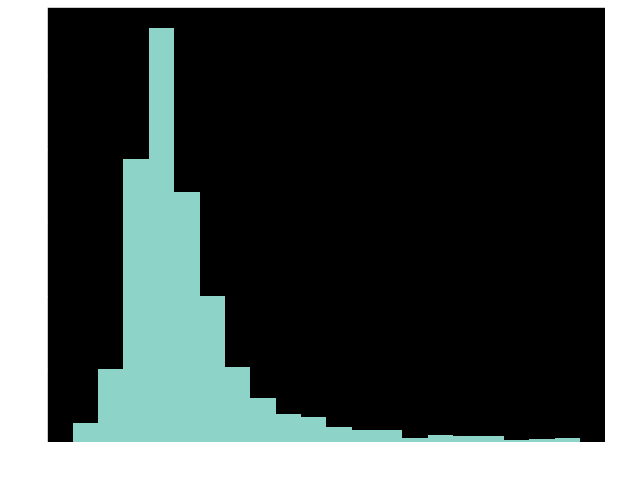

11
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.827467679977417 , p-value: 4.066857335342128e-31

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 39.54902367384966 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.1488431755841217
kurtosis, tail spread (< 3 is best): 7.0314929646809405


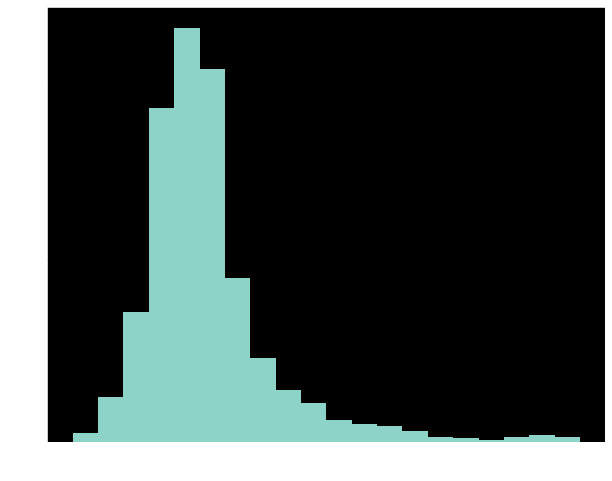

12
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7558451890945435 , p-value: 1.5483859257884872e-35

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 62.118694740560386 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.6023087616652356
kurtosis, tail spread (< 3 is best): 9.0946451166407


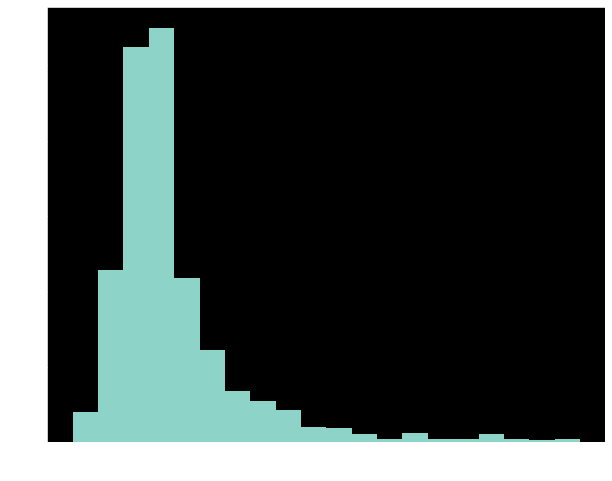

In [23]:
for i,month in enumerate(df_flights_by_month_noouts):
    print(i+1)
    sc.check_normal_dist(month['arr_delay'])

In [24]:
for i, month in enumerate(df_flights_by_month_noouts):
    print(i+1, month['arr_delay'].dropna().mean())
    print(i+1, month['arr_delay'].dropna().median())

1 -3.5771670190274842
1 -8.0
2 4.580299785867238
2 -4.0
3 0.8271221532091098
3 -6.0
4 0.08842105263157894
4 -8.0
5 2.981191222570533
5 -5.0
6 6.2418848167539265
6 -4.0
7 2.471561530506722
7 -7.0
8 3.5950413223140494
8 -6.0
9 -4.187238493723849
9 -9.0
10 -0.5230769230769231
10 -7.0
11 -4.594455852156058
11 -9.0
12 2.4840041279669762
12 -6.0


February, June, and August seem to have the most delays. February and June might coincide with New years, and summer vacations. August is return to school? Not certain.

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [26]:
origin_locations = df_flights['origin_city_name'].unique()

In [27]:
base_url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=5964df60e1c04a11883230245221204&q&format=json'

# locations
locations = origin_locations

# params
dates = [
    '2019-01-01',
    '2019-02-01',
    '2019-03-01',
    '2019-04-01',
    '2019-05-01',
    '2019-06-01',
    '2019-07-01',
    '2019-08-01',
    '2019-09-01',
    '2019-10-01',
    '2019-11-01',
    '2019-12-01']
enddates = [
    '2019-01-31',
    '2019-02-28',
    '2019-03-31',
    '2019-04-30',
    '2019-05-31',
    '2019-06-30',
    '2019-07-31',
    '2019-08-31',
    '2019-09-30',
    '2019-10-31',
    '2019-11-30',
    '2019-12-31']

In [28]:
len(locations)

354

In [29]:
weather_conditions = pd.read_csv(data_path / 'weather_conditions.csv', usecols=[0,1,2], sep=',')

In [30]:
weather_conditions.drop_duplicates(inplace=True)
weather_conditions.sort_values(by='overhead_code', inplace=True)

In [31]:
weather_conditions

# rain or like weather = > 263
# sunny = 113
# cloudy = 116, 119, 122
# snow = 227, 230

,overhead_code,daycondition,NightCondition
0,113,Sunny,Clear
40,116,Partly cloudy,Partly cloudy
80,119,Cloudy,Cloudy
120,122,Overcast,Overcast
160,143,Mist,Mist
200,176,Patchy rain possible,Patchy rain possible
240,179,Patchy snow possible,Patchy snow possible
280,182,Patchy sleet possible,Patchy sleet possible
320,185,Patchy freezing drizzle possible,Patchy freezing drizzle possible
360,200,Thundery outbreaks possible,Thundery outbreaks possible


In [32]:
weather_loc = {}

# for each location, save monthly weather
for location in locations:
    
    weather_req = []
    
    for i in range(0,12):
        
        # payload using params
        payload = dict(
            date=dates[i],
            enddate=enddates[i],
            q=location)
        
        weather_req.append(req.get(url=base_url, params=payload).json())
    
    weather_loc[location] = weather_req

In [33]:
cal = Calendar()
df_weather = pd.DataFrame(columns=['location', 'date', 'time', 'tempC', 'condition'])
df_placeholder = pd.DataFrame(columns=['location', 'date', 'time', 'tempC', 'condition'])
df_dict = {}

for location in locations:
    
    for m in range(0,12):
        for i,d in enumerate([x for x in cal.itermonthdates(2019, m+1) if x.month == m+1]):
            
            for j in range(len(weather_loc[location][m]['data']['weather'][i]['hourly'])):
                df_placeholder.loc[j+1, 'location'] = location
                df_placeholder.loc[j+1, 'date'] = d
                df_placeholder.loc[j+1, 'time'] = weather_loc[location][m]['data']['weather'][i]['hourly'][j]['time']
                df_placeholder.loc[j+1, 'tempC'] = int(weather_loc[location][m]['data']['weather'][i]['hourly'][j]['tempC'])
                df_placeholder.loc[j+1, 'condition'] = int(weather_loc[location][m]['data']['weather'][i]['hourly'][j]['weatherCode'])
            
            df_weather = pd.concat([df_weather, df_placeholder], ignore_index=True, axis=0)
        

In [149]:
df_weather.to_csv('./data/weather.csv')

In [161]:
df_weather_copy = df_weather.copy()

In [162]:
# add 6 hours to make it easier to separate into night/day
df_weather_copy['time'] = [time+600 for time in df_weather['time'].astype(int)]
df_weather_copy['tempC'] = [temp for temp in df_weather['tempC'].astype(int)]
df_weather_copy['condition'] = [con for con in df_weather['condition'].astype(int)]

In [163]:
daytime = []

for i,time in df_weather_copy['time'].iteritems():
    
    # code the time to 24 hours
    if time >= 2400:
        df_weather_copy.loc[i, 'time'] = time - 2400
    
    # convert 
    if df_weather_copy.loc[i, 'time'] >= 1200:
        daytime.append(0) # day
    else:
        daytime.append(1) # night

df_weather_copy = df_weather_copy.join(pd.Series(daytime, name='day/night'))

In [164]:
# rain or like weather = > 263
# sunny = 113
# cloudy = 116, 119, 122
# snow = 227, 230

df_weather_copy = df_weather_copy.drop(['time'], axis=1).groupby(['location', 'date', 'day/night'])['condition'].aggregate('median')

In [165]:
df_weather_copy = df_weather_copy.reset_index()

In [166]:
conditions = []

for condition in df_weather_copy['condition']:
    if condition > 250:
        conditions.append('rain')
    elif condition > 200 and condition <= 250:
        conditions.append('snow')
    elif condition < 115:
        conditions.append('sunny')
    else:
        conditions.append('cloudy')


In [167]:
df_weather_copy = df_weather_copy.join(pd.Series(conditions, name='cond_desc'))

In [168]:
df_weather_copy

,location,date,day/night,condition,cond_desc
0,"Aberdeen, SD",2019-01-01,0,113.0,sunny
1,"Aberdeen, SD",2019-01-01,1,218.0,snow
2,"Aberdeen, SD",2019-01-02,0,113.0,sunny
3,"Aberdeen, SD",2019-01-02,1,113.0,sunny
4,"Aberdeen, SD",2019-01-03,0,113.0,sunny
...,...,...,...,...,...
258415,"Yuma, AZ",2019-12-29,1,300.5,rain
258416,"Yuma, AZ",2019-12-30,0,281.0,rain
258417,"Yuma, AZ",2019-12-30,1,230.0,snow
258418,"Yuma, AZ",2019-12-31,0,120.5,cloudy


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [158]:
df_passengers.columns.to_list()

['departures_scheduled',
 'departures_performed',
 'payload',
 'seats',
 'passengers',
 'freight',
 'mail',
 'distance',
 'ramp_to_ramp',
 'air_time',
 'unique_carrier',
 'airline_id',
 'unique_carrier_name',
 'region',
 'carrier',
 'carrier_name',
 'carrier_group',
 'carrier_group_new',
 'origin_airport_id',
 'origin_city_market_id',
 'origin',
 'origin_city_name',
 'origin_country',
 'origin_country_name',
 'dest_airport_id',
 'dest_city_market_id',
 'dest',
 'dest_city_name',
 'dest_country',
 'dest_country_name',
 'aircraft_group',
 'aircraft_type',
 'aircraft_config',
 'year',
 'month',
 'distance_group',
 'class',
 'data_source']

In [159]:
# # convert fl_date to datetime format
# for i, date in df_flights['fl_date'].iteritems():
#     df_flights.loc[i, 'fl_date'] = dt.datetime.strptime(date, '%Y-%m-%d')
    
# generate a random day
def random_day(start_date, end_date, format):
    
    start_date = dt.datetime.strptime(start_date, format)
    end_date = dt.datetime.strptime(end_date, format)
    
    randdays= []
    for _ in range(10):
        randdays.append(np.random.randint(1, (end_date - start_date).days))
    
    for i,day in enumerate(randdays):
        randdays[i] = start_date + dt.timedelta(days=day)
    
    return randdays

In [160]:
# generate random days
days = random_day('2019-01-01', '2019-12-31', '%Y-%m-%d')

# loop through random days to generate distributions
for i,day in enumerate(days):
    
    df_taxi_in = pd.DataFrame(columns=['taxi_in'])
    df_taxi_out = pd.DataFrame(columns=['taxi_'])
    
    df_taxi_in.loc[i,'date'] = df_flights[pd.to_datetime(df_flights['fl_date']) == day]['taxi_in']
    df_taxi_out.loc[i,'date'] = df_flights[pd.to_datetime(df_flights['fl_date']) == day]['taxi_out']
    
    # use random days to take taxi in/out numbers and plot hist
    print(dt.datetime.strftime(day, '%Y-%m-%d'))
    print(df_taxi_in.describe(), df_taxi_out.describe())
    if len(df_taxi_in) > 3:
        sc.check_normal_dist(df_taxi_in)
    if len(df_taxi_out) > 3:
        sc.check_normal_dist(df_taxi_out)

ValueError: Incompatible indexer with Series

In [169]:
pd.to_datetime(df_flights['fl_date'])

0       2018-11-19
1       2018-11-19
2       2018-11-19
3       2018-11-19
4       2018-11-19
           ...    
99995   2018-11-24
99996   2018-11-24
99997   2018-11-24
99998   2018-11-24
99999   2018-11-24
Name: fl_date, Length: 100000, dtype: datetime64[ns]

In [170]:
for i in range(df_flights.shape[0]):
    df_flights.loc[i, 'month'] = int(pd.to_datetime(df_flights.loc[i, 'fl_date']).strftime('%m'))

In [172]:
months = [i for i in range(1,13)]

count = 0
for month in months:
    # print(df_flights['fl_date'][5:7] == month)
    flight_traffic = df_passengers[df_passengers['month'] == month]['departures_performed']
    df_taxis = df_flights.loc[df_flights['month'] == month]
    count += 1


In [111]:
df_taxis

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month


ValueError: x and y must have same first dimension, but have shapes (8145,) and (0,)

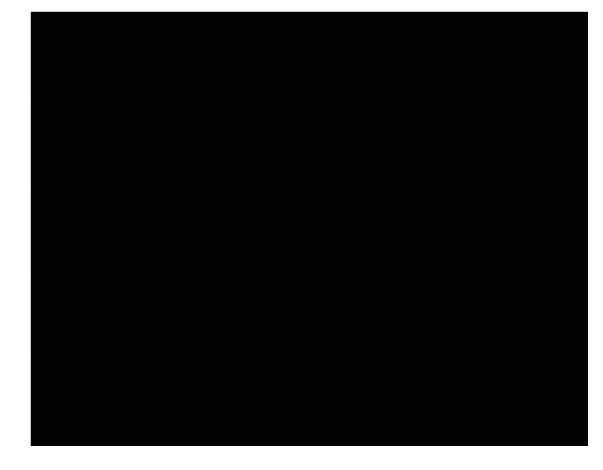

In [84]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(flight_traffic, df_taxis['taxi_in'])
ax.plot(flight_traffic, df_taxis['taxi_out'])
    

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

In [ ]:
train['total_delay'].sort

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?